In [1]:
# from qiskit import *
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.visualization import plot_state_qsphere, plot_state_city, plot_bloch_multivector
from qiskit.visualization import array_to_latex
import qiskit.quantum_info as qi

from qiskit_ionq import IonQProvider
# import gates
from qiskit_ionq import GPIGate, GPI2Gate, MSGate
from qiskit import Aer, execute, assemble

# numpy for linear algebra stuff
from numpy.random import randint, shuffle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# To supress the deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
#%run utility_functions.ipynb

provider = IonQProvider("RmK0yNkCDPmoxCH12uQ4U67lpu9kFgik")
native_simulator = provider.get_backend("ionq_simulator", gateset="native")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def fidelities(out000, out001, out010, out011, out100, out101, out110, out111, bitval):
    
    if bitval == 1:
        B = (out001 + out011 + out101 + out111)/1024
        E = (out010 + out011 + out110 + out111)/1024
        A = (out100 + out101 + out110 + out111)/1024
        
    if bitval == 0:
        B = (out010 + out000 + out110 + out100)/1024
        E = (out001 + out000 + out101 + out100)/1024
        A = (out000 + out001 + out010 + out011)/1024
        
    return B,E,A 

In [3]:
def alice_prepares(qc, bitval, basis):
    if basis == 'X' and bitval == 1: # initial state is |->
        #qc.x(0)
        #qc.h(0)
        qc.append(GPIGate(0), [0])
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(0), [0])
        return qc
    if basis == 'X' and bitval == 0: # initial state is |+>
        #qc.h(0)
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(0), [0])
        return qc
    if basis == 'Y' and bitval == 1: # initial state |-i>
        #qc.rx(np.pi/2, 0)
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(-1/8), [0])
        return qc
    if basis == 'Y' and bitval == 0: # initial state |+i>
        #qc.rx(-np.pi/2, 0)
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(1/8), [0])
        return qc

In [4]:
def measurement_prep(qc, bitval, basis):
    
    if basis == 'X':
        #qc.h(0)
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(0), [0])
        #qc.h(1)
        qc.append(GPI2Gate(1/4), [1])
        qc.append(GPIGate(0), [1])
        #qc.h(2)
        qc.append(GPI2Gate(1/4), [2])
        qc.append(GPIGate(0), [2])
        
    if basis == 'Y':
        #qc.rx(np.pi/2, 0)
        qc.append(GPI2Gate(0), [0])
        #qc.rx(np.pi/2, 1)
        qc.append(GPI2Gate(0), [1])
        #qc.rx(np.pi/2, 2)
        qc.append(GPI2Gate(0), [2])
    '''    
    if basis == 'Y':
        #qc.rx(np.pi/2, 0)
        qc.append(GPIGate(1/8), [0])
        qc.append(GPI2Gate(-.25), [0])
        
        #qc.rx(np.pi/2, 1)
        qc.append(GPIGate(1/8), [1])
        qc.append(GPI2Gate(-.25), [1])
        
        #qc.rx(np.pi/2, 2)
        qc.append(GPIGate(1/8), [2])
        qc.append(GPI2Gate(-.25), [2])
        '''

    return qc

In [5]:
def eve_clones(qc, theta2):
    theta = [np.pi/4, theta2, theta2]
        
    #Eve Prep
        
#    qc.append(GPIGate(1/8), [1])
#    qc.append(GPIGate(0), [1])
#    qc.append(GPI2Gate(1/4), [1])
#    qc.append(GPIGate((theta[0] + np.pi/4)/(2 * np.pi)), [1])
#    qc.append(GPI2Gate(1/4), [1])
#    qc.append(GPIGate(1/8), [1])

    qc.append(GPIGate(1/4), [1])
    
    qc.append(MSGate(0,0), [1,2])
    
    qc.append(GPIGate(1/8), [1])
    
    qc.append(GPIGate((np.pi/4 - theta[1])/(2 * np.pi)), [2])
    
    qc.append(MSGate(0,0), [2,1])
    
    qc.append(GPI2Gate(-1/4),[2])
     
    
    qc.append(GPIGate(1/8),[1])
    qc.append(GPIGate(0), [1])
    qc.append(GPI2Gate(1/4), [1])
    qc.append(GPIGate(theta[2]/(2*np.pi)), [1])
    qc.append(GPI2Gate(1/4), [1])
    qc.append(GPIGate(1/8), [1])
    
    #Eve Clone
    
    qc.append(GPI2Gate(1/4), [0])
    
    qc.append(MSGate(0,0), [0,1])
    
    qc.append(MSGate(0,0), [0,2])
    
    qc.append(GPI2Gate(1/4), [0])
    
    qc.append(GPIGate(1/8), [2])
    
    qc.append(GPIGate(1/8), [1])
    
    qc.append(MSGate(0,0), [1,0])
    
    qc.append(GPI2Gate(-1/4), [1])
    
    qc.append(MSGate(0,0), [2,0])
    
    qc.append(GPI2Gate(-1/4), [2])

    
    return qc

In [6]:
def cloningcircuit(theta2, bitval, basis):
    
    qc = QuantumCircuit(3,3)
    
    # Alice prepares her qubit to send
    alice_prepares(qc, bitval, basis)
    qc.barrier()
    
    # Eve clones the flying qubit
    eve_clones(qc, theta2)
    
    qc.barrier()
    # Bob and Eve prepare to measure
    measurement_prep(qc, bitval, basis)
    
    qc.barrier()
    
    # Bob and Eve measure
    qc.measure(0,0)
    qc.measure(1,1)
    qc.measure(2,2)
    
    return qc

def displayresult(qc,alice_bit=0,show=True,useIonQ=False):
        
#     ionq = provider.get_backend("ionq_simulator")
#     job = ionq.run(qc, backend=ionq, shots = 1024)
#     counts = job.result().get_counts()
    
    job = native_simulator.run(qc)
    probs = job.get_probabilities()
    counts = job.result().get_counts()
    
#     if show:
    print ("Counts:",counts)

    prob_bob = 0
    prob_eve = 0
    prob_ancilla = 0
    for key in counts.keys():
        if int(list(key)[-1]) == alice_bit:
            prob_bob += counts[key]/1024
        if int(list(key)[-2]) == alice_bit:
            prob_eve += counts[key]/1024
        if int(list(key)[-3]) == alice_bit:
            prob_ancilla += counts[key]/1024
    print("The probability of Bob measuring the correct bit is ", prob_bob, "and the probability of Eve eavesdropping the correct bit is", prob_eve, " and the probability of ancilla being the correct bit is", prob_ancilla)
    if show:
#         print("The probability of Bob measuring the correct bit is ", prob_bob, "and the probability of Alice eavesdropping the correct bit is", prob_alice)
        # plot the histogram of the results
        display(plot_histogram(counts))
#         display(plot_bloch_multivector(sv))
#         display(array_to_latex(sv))
    
    return prob_bob, prob_eve, prob_ancilla, counts

Counts: {'000': 732, '011': 21, '101': 88, '110': 183}
The probability of Bob measuring the correct bit is  0.8935546875 and the probability of Eve eavesdropping the correct bit is 0.80078125  and the probability of ancilla being the correct bit is 0.7353515625


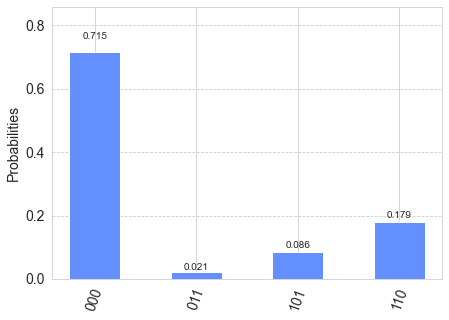

In [7]:
qc = cloningcircuit(np.pi/8 + 0.079, 0, 'X')
qc.draw()
prob_bob,prob_eve,prob_ancilla,counts = displayresult(qc,alice_bit=0,show=True,useIonQ=True)

Counts: {'011': 508, '110': 516}
The probability of Bob measuring the correct bit is  0.50390625 and the probability of Eve eavesdropping the correct bit is 0  and the probability of ancilla being the correct bit is 0.49609375
Counts: {'000': 6, '011': 649, '101': 17, '110': 352}
The probability of Bob measuring the correct bit is  0.349609375 and the probability of Eve eavesdropping the correct bit is 0.0224609375  and the probability of ancilla being the correct bit is 0.6396484375
Counts: {'000': 10, '011': 742, '101': 89, '110': 183}
The probability of Bob measuring the correct bit is  0.1884765625 and the probability of Eve eavesdropping the correct bit is 0.0966796875  and the probability of ancilla being the correct bit is 0.734375
Counts: {'000': 19, '011': 745, '101': 208, '110': 52}
The probability of Bob measuring the correct bit is  0.0693359375 and the probability of Eve eavesdropping the correct bit is 0.2216796875  and the probability of ancilla being the correct bit is 

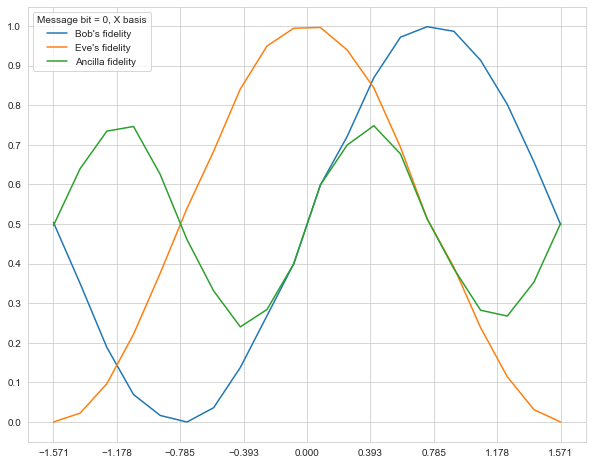

In [20]:
ts = np.linspace(-np.pi/2, np.pi/2, 20)
B = []
E = []
A = []
for j in range(len(ts)):
    
    qc = cloningcircuit(ts[j], 0, 'X')
    prob_bob,prob_eve,prob_ancilla,counts = displayresult(qc,alice_bit=0,show=False,useIonQ=True)
    
    B.append(prob_bob)
    E.append(prob_eve)
    A.append(prob_ancilla)
    
    
B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(ts, B, label = "Bob's fidelity")
plt.plot(ts, E, label = "Eve's fidelity")
plt.plot(ts, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Message bit = 0, X basis")
plt.show()

In [8]:
native_qpu = provider.get_backend("ionq_qpu", gateset="native")

In [9]:
def submitjob(alice_bit=0,alice_base="X",theta2=np.pi/8 + 0.079):
    
    qc = cloningcircuit(theta2, alice_bit, alice_base)    
#     display(qc.draw(output='mpl'))
    native_qpu = provider.get_backend("ionq_qpu", gateset="native")
    job = native_qpu.run(qc)
    
#     ionq = provider.get_backend("ionq_qpu")
#     job = ionq.run(qc, backend=ionq, shots = 1024)
    
    return job.job_id()

## Test job

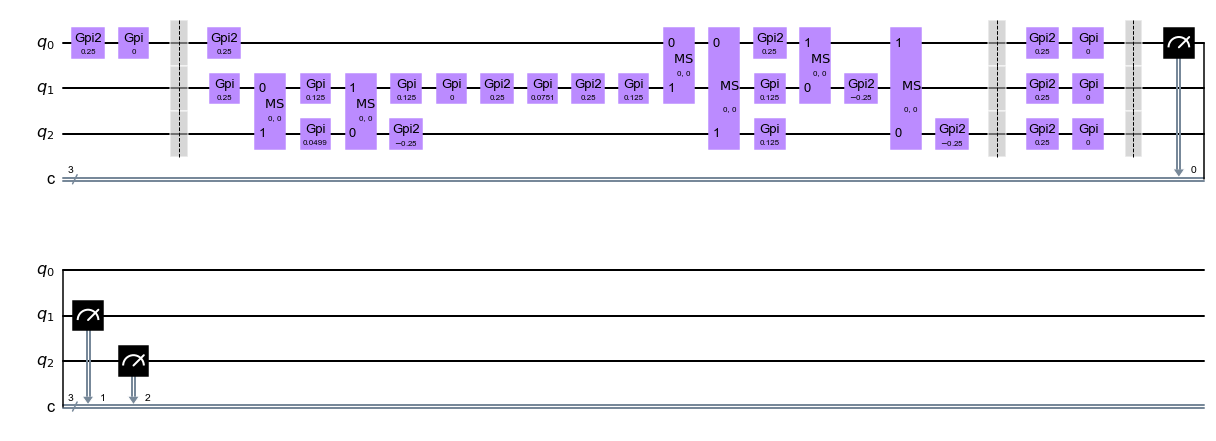

'2fc830d0-d46a-4a18-8e60-9ab4b22f244d'

In [38]:
jobid = submitjob(alice_bit=0,alice_base="X",theta2=np.pi/8 + 0.079)
jobid

In [10]:
def getjobresult(id = "",alice_bit=0):
    ionq = provider.get_backend("ionq_qpu")
    retrieved = ionq.retrieve_job(id) 
    counts = retrieved.result().get_counts()
#     print(counts)
#     plot_histogram(counts)

    prob_bob = 0
    prob_eve = 0
    prob_ancilla = 0
    for key in counts.keys():
        if int(list(key)[-1]) == alice_bit:
            prob_bob += counts[key]/1024
        if int(list(key)[-2]) == alice_bit:
            prob_eve += counts[key]/1024
        if int(list(key)[-3]) == alice_bit:
            prob_ancilla += counts[key]/1024

        err_bob = 1 - prob_bob
        err_eve = 1 - prob_eve
        err_ancilla = 1 - prob_ancilla
            
    return prob_bob, prob_eve, prob_ancilla, err_bob, err_eve, err_ancilla, counts

In [7]:
qpu_prob_bob, qpu_prob_eve, qpu_prob_ancilla, qpu_err_bob, qpu_err_eve, qpu_err_ancilla, qpu_counts = getjobresult(id = '2fc830d0-d46a-4a18-8e60-9ab4b22f244d', alice_bit=0)
qpu_prob_bob, qpu_prob_eve, qpu_prob_ancilla, qpu_err_bob, qpu_err_eve, qpu_err_ancilla, qpu_counts

(0.869140625,
 0.76171875,
 0.6962890625,
 0.130859375,
 0.23828125,
 0.3037109375,
 {'000': 647,
  '001': 11,
  '010': 26,
  '011': 29,
  '100': 50,
  '101': 72,
  '110': 167,
  '111': 22})

## Theta2 values

In [11]:
ts = np.linspace(-np.pi/2, np.pi/2, 20)
ts

array([-1.57079633, -1.40544935, -1.24010236, -1.07475538, -0.9094084 ,
       -0.74406142, -0.57871444, -0.41336745, -0.24802047, -0.08267349,
        0.08267349,  0.24802047,  0.41336745,  0.57871444,  0.74406142,
        0.9094084 ,  1.07475538,  1.24010236,  1.40544935,  1.57079633])

## bit = 0, base = X

Counts: {'011': 514, '110': 510}
The probability of Bob measuring the correct bit is  0.498046875 and the probability of Eve eavesdropping the correct bit is 0  and the probability of ancilla being the correct bit is 0.501953125
Counts: {'000': 8, '011': 645, '101': 15, '110': 356}
The probability of Bob measuring the correct bit is  0.35546875 and the probability of Eve eavesdropping the correct bit is 0.0224609375  and the probability of ancilla being the correct bit is 0.6376953125
Counts: {'000': 20, '011': 728, '101': 93, '110': 183}
The probability of Bob measuring the correct bit is  0.1982421875 and the probability of Eve eavesdropping the correct bit is 0.1103515625  and the probability of ancilla being the correct bit is 0.73046875
Counts: {'000': 16, '011': 727, '101': 205, '110': 76}
The probability of Bob measuring the correct bit is  0.08984375 and the probability of Eve eavesdropping the correct bit is 0.2158203125  and the probability of ancilla being the correct bit is

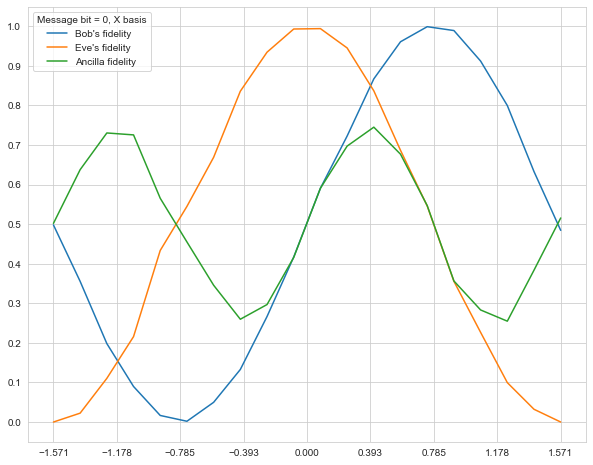

In [18]:
ts = np.linspace(-np.pi/2, np.pi/2, 20)
B = []
E = []
A = []
for j in range(len(ts)):
    
    qc = cloningcircuit(ts[j], 0, 'X')
    prob_bob,prob_eve,prob_ancilla,counts = displayresult(qc,alice_bit=0,show=False,useIonQ=True)
    
    B.append(prob_bob)
    E.append(prob_eve)
    A.append(prob_ancilla)
    
    
B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(ts, B, label = "Bob's fidelity")
plt.plot(ts, E, label = "Eve's fidelity")
plt.plot(ts, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Message bit = 0, X basis")
plt.show()

In [51]:
# jobs = []
# for val in ts:
#     job = submitjob(alice_bit=0,alice_base="X",theta2=val)
#     jobs.append(job)
# jobs

['f131e927-257a-4def-8db6-20aea3a1d70c',
 'fc483669-20a8-46f1-bc01-cf1ce6f3fe09',
 '6d92ffb9-6c99-4cd9-913e-1be3c0309a44',
 'cfa23c24-8eff-4fcf-b302-2f94d66ade56',
 '5300c77e-cb5d-4bc9-a492-b0dc88bf0a97',
 '5574d4e9-600f-4bcb-b3df-6109305b25cb',
 '293ff37f-5ab0-43a9-a043-75707258ee9b',
 '99ec745f-02d9-4cf1-9e65-f5213f789aff',
 'f666515c-c3ce-4b3e-a33b-fe2cb4d46303',
 'c00f30c7-8413-40d3-968a-f404b3b0ba5d',
 'b6522ede-758d-46bf-a83e-cbc0c453fba2',
 '0dfebad1-c300-405c-83ef-269d8ae7dd55',
 '94bfb657-5c4b-4d49-9105-138bbbacb7ad',
 '71c4164e-f2cb-4392-9ae5-9cc21cf98152',
 '0cdf4458-7515-4d05-adc6-87bb8b73451e',
 'ee6e2f82-b4af-49aa-8724-cf68ebc98944',
 '6cba9e27-9280-4c98-b372-b9e634142f59',
 '336775eb-0c86-4cb9-b97d-ff1ef3b5ea71',
 'bbd57050-96b4-4327-a706-171f061ffbec',
 '4b1fbb10-c315-45e4-859f-67e03f83f058']

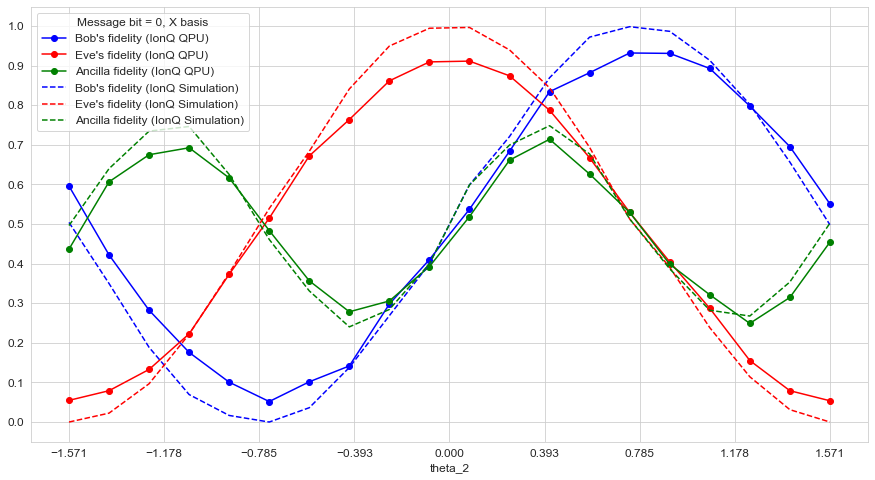

In [30]:
jobs_run1 = ['f131e927-257a-4def-8db6-20aea3a1d70c',
 'fc483669-20a8-46f1-bc01-cf1ce6f3fe09',
 '6d92ffb9-6c99-4cd9-913e-1be3c0309a44',
 'cfa23c24-8eff-4fcf-b302-2f94d66ade56',
 '5300c77e-cb5d-4bc9-a492-b0dc88bf0a97',
 '5574d4e9-600f-4bcb-b3df-6109305b25cb',
 '293ff37f-5ab0-43a9-a043-75707258ee9b',
 '99ec745f-02d9-4cf1-9e65-f5213f789aff',
 'f666515c-c3ce-4b3e-a33b-fe2cb4d46303',
 'c00f30c7-8413-40d3-968a-f404b3b0ba5d',
 'b6522ede-758d-46bf-a83e-cbc0c453fba2',
 '0dfebad1-c300-405c-83ef-269d8ae7dd55',
 '94bfb657-5c4b-4d49-9105-138bbbacb7ad',
 '71c4164e-f2cb-4392-9ae5-9cc21cf98152',
 '0cdf4458-7515-4d05-adc6-87bb8b73451e',
 'ee6e2f82-b4af-49aa-8724-cf68ebc98944',
 '6cba9e27-9280-4c98-b372-b9e634142f59',
 '336775eb-0c86-4cb9-b97d-ff1ef3b5ea71',
 'bbd57050-96b4-4327-a706-171f061ffbec',
 '4b1fbb10-c315-45e4-859f-67e03f83f058']

ts = np.linspace(-np.pi/2, np.pi/2, 20)
QPU_B = []
QPU_E = []
QPU_A = []
for idx in range(len(jobs_run1)):
    
    qpu_prob_bob, qpu_prob_eve, qpu_prob_ancilla, qpu_err_bob, qpu_err_eve, qpu_err_ancilla, qpu_counts = getjobresult(id = jobs_run1[idx], alice_bit=0)

    
    QPU_B.append(qpu_prob_bob)
    QPU_E.append(qpu_prob_eve)
    QPU_A.append(qpu_prob_ancilla)
    
    
QPU_B = np.array(QPU_B)
QPU_E = np.array(QPU_E)
QPU_A = np.array(QPU_A)

plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 12})

plt.plot(ts, QPU_B, label = "Bob's fidelity (IonQ QPU)", marker='o',color='blue')
plt.plot(ts, QPU_E, label = "Eve's fidelity (IonQ QPU)",marker='o',color='red')
plt.plot(ts, QPU_A, label = "Ancilla fidelity (IonQ QPU)",marker='o',color='green')

plt.plot(ts, B, label = "Bob's fidelity (IonQ Simulation)",linestyle='--',color='blue')
plt.plot(ts, E, label = "Eve's fidelity (IonQ Simulation)",linestyle='--',color='red')
plt.plot(ts, A, label = "Ancilla fidelity (IonQ Simulation)",linestyle='--',color='green')

plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Message bit = 0, X basis")

plt.xlabel('theta_2')
plt.show()

## bit = 0, base = Y

Counts: {'010': 507, '111': 517}
The probability of Bob measuring the correct bit is  0.4951171875 and the probability of Eve eavesdropping the correct bit is 0  and the probability of ancilla being the correct bit is 0.4951171875
Counts: {'001': 12, '010': 687, '100': 17, '111': 308}
The probability of Bob measuring the correct bit is  0.6875 and the probability of Eve eavesdropping the correct bit is 0.0283203125  and the probability of ancilla being the correct bit is 0.6826171875
Counts: {'001': 11, '010': 741, '100': 81, '111': 191}
The probability of Bob measuring the correct bit is  0.802734375 and the probability of Eve eavesdropping the correct bit is 0.08984375  and the probability of ancilla being the correct bit is 0.734375
Counts: {'001': 26, '010': 714, '100': 222, '111': 62}
The probability of Bob measuring the correct bit is  0.9140625 and the probability of Eve eavesdropping the correct bit is 0.2421875  and the probability of ancilla being the correct bit is 0.7226562

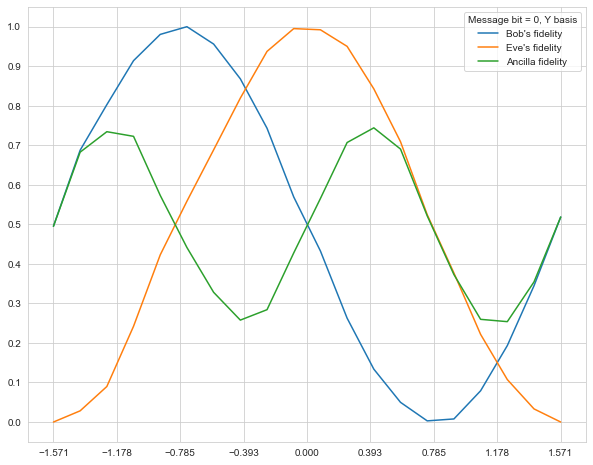

In [19]:
ts = np.linspace(-np.pi/2, np.pi/2, 20)
B = []
E = []
A = []
for j in range(len(ts)):
    
    qc = cloningcircuit(ts[j], 0, 'Y')
    prob_bob,prob_eve,prob_ancilla,counts = displayresult(qc,alice_bit=0,show=False,useIonQ=True)
    
    B.append(prob_bob)
    E.append(prob_eve)
    A.append(prob_ancilla)
    
    
B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(ts, B, label = "Bob's fidelity")
plt.plot(ts, E, label = "Eve's fidelity")
plt.plot(ts, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Message bit = 0, Y basis")
plt.show()

In [12]:
# jobs = []
# for val in ts:
#     job = submitjob(alice_bit=0,alice_base="Y",theta2=val)
#     jobs.append(job)
# jobs

['3c20be1c-4cc1-4588-99a6-026d6cd18504',
 'e2e1ca70-5d48-470e-a554-77e7ad11ff99',
 'd48873c2-4864-49dd-9a4a-42ad6037f62d',
 '97ef44d9-6308-4906-9660-ac939836f36e',
 '688b0734-0a08-4d9e-b9ac-00f91cbc5303',
 'f1fd6286-874f-40d8-8b3c-c52896330e3d',
 '39f70893-7814-4fa7-b20d-89ae5118574e',
 '22a44dde-4ecf-4da5-ad55-b014eaee1567',
 'e779952b-ac17-462f-9dd7-1e25ab4f2986',
 '1cbdba0f-39da-4935-b062-043ec647a87f',
 '7dec8c6e-17cf-46f0-a9a5-09550953e266',
 'd5dabd99-78f1-4115-82e2-838cbaa68ebf',
 '1b9bdd0a-9f91-429d-8629-01f838f22ba7',
 '5e9421b0-5277-4fe9-9632-1995d9bf1ed7',
 '28d8205e-2dc0-4e2f-b012-005a2e1e9159',
 'acab829d-973c-4863-8030-28181a97a8ac',
 '2b362efc-7a3e-4807-8365-2d82f109bc73',
 '157613d4-e505-4097-853e-a0f5f6ce798a',
 '716aa1ac-2dd0-4269-8427-c976e7f3473c',
 '94e9161c-9e89-46ea-86c5-82da73f45461']

In [16]:
jobs_run1 = ['3c20be1c-4cc1-4588-99a6-026d6cd18504',
 'e2e1ca70-5d48-470e-a554-77e7ad11ff99',
 'd48873c2-4864-49dd-9a4a-42ad6037f62d',
 '97ef44d9-6308-4906-9660-ac939836f36e',
 '688b0734-0a08-4d9e-b9ac-00f91cbc5303',
 'f1fd6286-874f-40d8-8b3c-c52896330e3d',
 '39f70893-7814-4fa7-b20d-89ae5118574e',
 '22a44dde-4ecf-4da5-ad55-b014eaee1567',
 'e779952b-ac17-462f-9dd7-1e25ab4f2986',
 '1cbdba0f-39da-4935-b062-043ec647a87f',
 '7dec8c6e-17cf-46f0-a9a5-09550953e266',
 'd5dabd99-78f1-4115-82e2-838cbaa68ebf',
 '1b9bdd0a-9f91-429d-8629-01f838f22ba7',
 '5e9421b0-5277-4fe9-9632-1995d9bf1ed7',
 '28d8205e-2dc0-4e2f-b012-005a2e1e9159',
 'acab829d-973c-4863-8030-28181a97a8ac',
 '2b362efc-7a3e-4807-8365-2d82f109bc73',
 '157613d4-e505-4097-853e-a0f5f6ce798a',
 '716aa1ac-2dd0-4269-8427-c976e7f3473c',
 '94e9161c-9e89-46ea-86c5-82da73f45461']

ts = np.linspace(-np.pi/2, np.pi/2, 20)
QPU_B = []
QPU_E = []
QPU_A = []
for idx in range(len(jobs_run1)):
    
    qpu_prob_bob, qpu_prob_eve, qpu_prob_ancilla, qpu_err_bob, qpu_err_eve, qpu_err_ancilla, qpu_counts = getjobresult(id = jobs_run1[idx], alice_bit=0)

    
    QPU_B.append(qpu_prob_bob)
    QPU_E.append(qpu_prob_eve)
    QPU_A.append(qpu_prob_ancilla)
    
    
QPU_B = np.array(QPU_B)
QPU_E = np.array(QPU_E)
QPU_A = np.array(QPU_A)

plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 12})

plt.plot(ts, QPU_B, label = "Bob's fidelity (IonQ QPU)", marker='o',color='blue')
plt.plot(ts, QPU_E, label = "Eve's fidelity (IonQ QPU)",marker='o',color='red')
plt.plot(ts, QPU_A, label = "Ancilla fidelity (IonQ QPU)",marker='o',color='green')

plt.plot(ts, B, label = "Bob's fidelity (IonQ Simulation)",linestyle='--',color='blue')
plt.plot(ts, E, label = "Eve's fidelity (IonQ Simulation)",linestyle='--',color='red')
plt.plot(ts, A, label = "Ancilla fidelity (IonQ Simulation)",linestyle='--',color='green')

plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Message bit = 0, Y basis")

plt.xlabel('theta_2')
plt.show()

KeyboardInterrupt: 

## bit = 1, base = X

Counts: {'001': 509, '100': 515}
The probability of Bob measuring the correct bit is  0.4970703125 and the probability of Eve eavesdropping the correct bit is 0  and the probability of ancilla being the correct bit is 0.5029296875
Counts: {'001': 323, '010': 19, '100': 672, '111': 10}
The probability of Bob measuring the correct bit is  0.3251953125 and the probability of Eve eavesdropping the correct bit is 0.0283203125  and the probability of ancilla being the correct bit is 0.666015625
Counts: {'001': 179, '010': 70, '100': 752, '111': 23}
The probability of Bob measuring the correct bit is  0.197265625 and the probability of Eve eavesdropping the correct bit is 0.0908203125  and the probability of ancilla being the correct bit is 0.7568359375
Counts: {'001': 68, '010': 185, '100': 747, '111': 24}
The probability of Bob measuring the correct bit is  0.08984375 and the probability of Eve eavesdropping the correct bit is 0.2041015625  and the probability of ancilla being the correct b

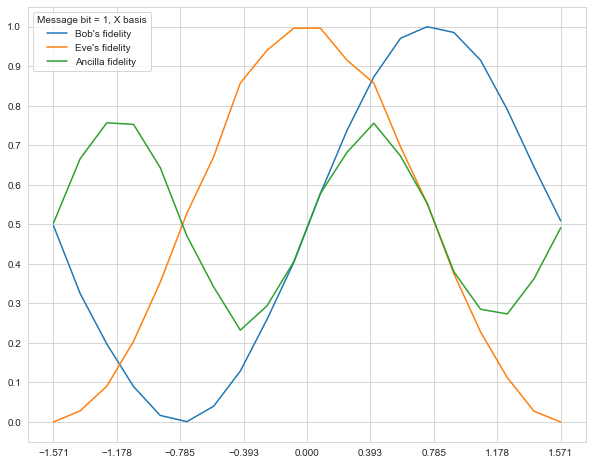

In [22]:
ts = np.linspace(-np.pi/2, np.pi/2, 20)
B = []
E = []
A = []
for j in range(len(ts)):
    
    qc = cloningcircuit(ts[j], 1, 'X')
    prob_bob,prob_eve,prob_ancilla,counts = displayresult(qc,alice_bit=1,show=False,useIonQ=True)
    
    B.append(prob_bob)
    E.append(prob_eve)
    A.append(prob_ancilla)
    
    
B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(ts, B, label = "Bob's fidelity")
plt.plot(ts, E, label = "Eve's fidelity")
plt.plot(ts, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Message bit = 1, X basis")
plt.show()

In [14]:
# jobs = []
# for val in ts:
#     job = submitjob(alice_bit=1,alice_base="X",theta2=val)
#     jobs.append(job)
# jobs

['e86e54ec-56f3-4c67-81e4-488c0a09eb03',
 '86b2942c-77db-498d-b90d-6b8eae7f4851',
 'aee1c6ba-59c6-4f34-b3ed-c99bb7e97231',
 'c897a4a1-201e-4058-8aa6-ef7055c319eb',
 '23119bae-c1d4-4777-aa37-dce28c6140ce',
 '82ae5abe-0b95-4446-b09c-8304b6436c16',
 'c62861cc-fe91-425e-9431-1891c7efa9d6',
 '7d5c17d1-68f2-4cdf-9d3b-7275355b037e',
 'cf2ee7bd-02ef-443e-af2c-85b68d5cac95',
 '88ed6df6-831a-4657-a817-9dcc3fcc4301',
 '11bd2449-199a-476a-b337-fb049baffc46',
 '624b991b-115a-4d7a-80c3-e463fc2d5b51',
 '83e0ef8c-20d3-4dae-bc8f-865d733129be',
 '1c265577-7aee-4439-83c1-67d86d46a7d1',
 'd6b9c99b-c740-4d17-95e4-a3b39fb6b899',
 'dbe73f0e-01ec-49d3-a0c6-8d8698d6f32f',
 'e6d04dec-0336-4f43-8c8f-5725c3dc9eb1',
 '5d76e05a-bd4e-41f4-92ef-ecffbe2b9d24',
 '5eadb453-edd4-4cc6-9b7e-1a392c5dd59a',
 '7ef5e319-e9a3-486d-9b78-5e333aed040e']

In [15]:
jobs_run1 = ['e86e54ec-56f3-4c67-81e4-488c0a09eb03',
 '86b2942c-77db-498d-b90d-6b8eae7f4851',
 'aee1c6ba-59c6-4f34-b3ed-c99bb7e97231',
 'c897a4a1-201e-4058-8aa6-ef7055c319eb',
 '23119bae-c1d4-4777-aa37-dce28c6140ce',
 '82ae5abe-0b95-4446-b09c-8304b6436c16',
 'c62861cc-fe91-425e-9431-1891c7efa9d6',
 '7d5c17d1-68f2-4cdf-9d3b-7275355b037e',
 'cf2ee7bd-02ef-443e-af2c-85b68d5cac95',
 '88ed6df6-831a-4657-a817-9dcc3fcc4301',
 '11bd2449-199a-476a-b337-fb049baffc46',
 '624b991b-115a-4d7a-80c3-e463fc2d5b51',
 '83e0ef8c-20d3-4dae-bc8f-865d733129be',
 '1c265577-7aee-4439-83c1-67d86d46a7d1',
 'd6b9c99b-c740-4d17-95e4-a3b39fb6b899',
 'dbe73f0e-01ec-49d3-a0c6-8d8698d6f32f',
 'e6d04dec-0336-4f43-8c8f-5725c3dc9eb1',
 '5d76e05a-bd4e-41f4-92ef-ecffbe2b9d24',
 '5eadb453-edd4-4cc6-9b7e-1a392c5dd59a',
 '7ef5e319-e9a3-486d-9b78-5e333aed040e']

ts = np.linspace(-np.pi/2, np.pi/2, 20)
QPU_B = []
QPU_E = []
QPU_A = []
for idx in range(len(jobs_run1)):
    
    qpu_prob_bob, qpu_prob_eve, qpu_prob_ancilla, qpu_err_bob, qpu_err_eve, qpu_err_ancilla, qpu_counts = getjobresult(id = jobs_run1[idx], alice_bit=1)

    
    QPU_B.append(qpu_prob_bob)
    QPU_E.append(qpu_prob_eve)
    QPU_A.append(qpu_prob_ancilla)
    
    
QPU_B = np.array(QPU_B)
QPU_E = np.array(QPU_E)
QPU_A = np.array(QPU_A)

plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 12})

plt.plot(ts, QPU_B, label = "Bob's fidelity (IonQ QPU)", marker='o',color='blue')
plt.plot(ts, QPU_E, label = "Eve's fidelity (IonQ QPU)",marker='o',color='red')
plt.plot(ts, QPU_A, label = "Ancilla fidelity (IonQ QPU)",marker='o',color='green')

plt.plot(ts, B, label = "Bob's fidelity (IonQ Simulation)",linestyle='--',color='blue')
plt.plot(ts, E, label = "Eve's fidelity (IonQ Simulation)",linestyle='--',color='red')
plt.plot(ts, A, label = "Ancilla fidelity (IonQ Simulation)",linestyle='--',color='green')

plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Message bit = 1, X basis")

plt.xlabel('theta_2')
plt.show()

KeyboardInterrupt: 

## bit = 1, base = Y

Counts: {'000': 521, '101': 503}
The probability of Bob measuring the correct bit is  0.4912109375 and the probability of Eve eavesdropping the correct bit is 0  and the probability of ancilla being the correct bit is 0.4912109375
Counts: {'000': 333, '011': 13, '101': 664, '110': 14}
The probability of Bob measuring the correct bit is  0.6611328125 and the probability of Eve eavesdropping the correct bit is 0.0263671875  and the probability of ancilla being the correct bit is 0.662109375
Counts: {'000': 187, '011': 80, '101': 738, '110': 19}
The probability of Bob measuring the correct bit is  0.798828125 and the probability of Eve eavesdropping the correct bit is 0.0966796875  and the probability of ancilla being the correct bit is 0.7392578125
Counts: {'000': 71, '011': 208, '101': 719, '110': 26}
The probability of Bob measuring the correct bit is  0.9052734375 and the probability of Eve eavesdropping the correct bit is 0.228515625  and the probability of ancilla being the correct 

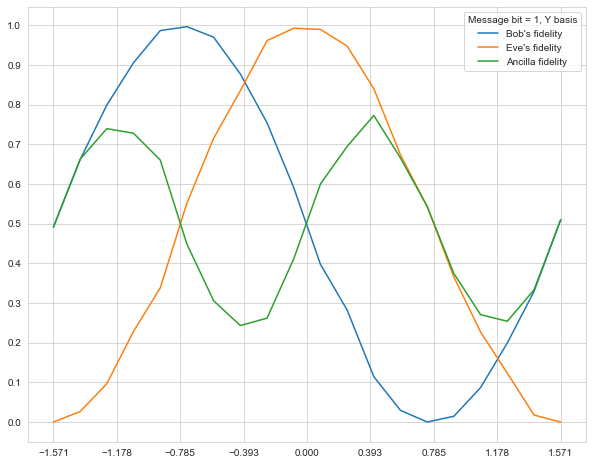

In [21]:
ts = np.linspace(-np.pi/2, np.pi/2, 20)
B = []
E = []
A = []
for j in range(len(ts)):
    
    qc = cloningcircuit(ts[j], 1, 'Y')
    prob_bob,prob_eve,prob_ancilla,counts = displayresult(qc,alice_bit=1,show=False,useIonQ=True)
    
    B.append(prob_bob)
    E.append(prob_eve)
    A.append(prob_ancilla)
    
    
B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(ts, B, label = "Bob's fidelity")
plt.plot(ts, E, label = "Eve's fidelity")
plt.plot(ts, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Message bit = 1, Y basis")
plt.show()

In [17]:
jobs = []
for val in ts:
    job = submitjob(alice_bit=1,alice_base="Y",theta2=val)
    jobs.append(job)
jobs

['9bc3cd9f-6a59-4eda-9bae-7bf32c4d0cfa',
 '705b769e-7eda-4f71-900d-f2c25e70d3ab',
 '741b3907-79ef-4dd9-84f0-fe481cfc7773',
 'fabfbe7b-73b7-4774-a586-c6ba1f6e2e96',
 '1fd4f105-9da5-48ce-80b8-6fc8a37e2ace',
 'c7f498dd-b9e1-4db8-b8af-508dcef521c6',
 'd1ddf550-4f8f-49d7-9593-a268a799804a',
 '4d9e2646-b6e7-468a-9d42-65b89997c065',
 'f66a4385-2f8d-48ad-bb6c-cd1e49617657',
 '7087f504-9e0f-4788-a97a-d39145bff5dc',
 'e6be2a42-91b2-443a-b4e8-b6397d4bc8c7',
 'dd560f35-e8cb-4409-a7a8-2d3dc8281cf6',
 'e0f98b2c-3c06-41a2-a9e7-57d6ed19d1a0',
 '13bf28d5-ff98-4013-8e80-663bcc7efc91',
 '9a4edf43-d232-4ee8-a969-e8c7a64dd0f7',
 '36ebeca0-a68f-41e4-b4fa-ca53b6d1c81e',
 '03572452-4dd8-4322-aec7-16668943751b',
 '9983bf45-0ec2-47ca-9a12-9198a50e2f87',
 'c24139c9-45e9-469f-b1f5-c48413ac5a8f',
 'b9bbfccf-1dc2-469c-822e-5ae34e7c224e']

In [ ]:
jobs_run1 = ['9bc3cd9f-6a59-4eda-9bae-7bf32c4d0cfa',
 '705b769e-7eda-4f71-900d-f2c25e70d3ab',
 '741b3907-79ef-4dd9-84f0-fe481cfc7773',
 'fabfbe7b-73b7-4774-a586-c6ba1f6e2e96',
 '1fd4f105-9da5-48ce-80b8-6fc8a37e2ace',
 'c7f498dd-b9e1-4db8-b8af-508dcef521c6',
 'd1ddf550-4f8f-49d7-9593-a268a799804a',
 '4d9e2646-b6e7-468a-9d42-65b89997c065',
 'f66a4385-2f8d-48ad-bb6c-cd1e49617657',
 '7087f504-9e0f-4788-a97a-d39145bff5dc',
 'e6be2a42-91b2-443a-b4e8-b6397d4bc8c7',
 'dd560f35-e8cb-4409-a7a8-2d3dc8281cf6',
 'e0f98b2c-3c06-41a2-a9e7-57d6ed19d1a0',
 '13bf28d5-ff98-4013-8e80-663bcc7efc91',
 '9a4edf43-d232-4ee8-a969-e8c7a64dd0f7',
 '36ebeca0-a68f-41e4-b4fa-ca53b6d1c81e',
 '03572452-4dd8-4322-aec7-16668943751b',
 '9983bf45-0ec2-47ca-9a12-9198a50e2f87',
 'c24139c9-45e9-469f-b1f5-c48413ac5a8f',
 'b9bbfccf-1dc2-469c-822e-5ae34e7c224e']

ts = np.linspace(-np.pi/2, np.pi/2, 20)
QPU_B = []
QPU_E = []
QPU_A = []
for idx in range(len(jobs_run1)):
    
    qpu_prob_bob, qpu_prob_eve, qpu_prob_ancilla, qpu_err_bob, qpu_err_eve, qpu_err_ancilla, qpu_counts = getjobresult(id = jobs_run1[idx], alice_bit=1)

    
    QPU_B.append(qpu_prob_bob)
    QPU_E.append(qpu_prob_eve)
    QPU_A.append(qpu_prob_ancilla)
    
    
QPU_B = np.array(QPU_B)
QPU_E = np.array(QPU_E)
QPU_A = np.array(QPU_A)

plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 12})

plt.plot(ts, QPU_B, label = "Bob's fidelity (IonQ QPU)", marker='o',color='blue')
plt.plot(ts, QPU_E, label = "Eve's fidelity (IonQ QPU)",marker='o',color='red')
plt.plot(ts, QPU_A, label = "Ancilla fidelity (IonQ QPU)",marker='o',color='green')

plt.plot(ts, B, label = "Bob's fidelity (IonQ Simulation)",linestyle='--',color='blue')
plt.plot(ts, E, label = "Eve's fidelity (IonQ Simulation)",linestyle='--',color='red')
plt.plot(ts, A, label = "Ancilla fidelity (IonQ Simulation)",linestyle='--',color='green')

plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Message bit = 1, Y basis")

plt.xlabel('theta_2')
plt.show()